<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0804new%5D_machine_learning_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM (20Í∞ú Í≥ºÍ±∞ ‚Üí 5Í∞ú ÎØ∏Îûò)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
# np.random.seed(42)
# days = 90
# points_per_day = 24 * 12

# # Î≥µÏû°Ìïú Îç∞Ïù¥ÌÑ∞
# # 1. Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
# np.random.seed(42)
# total_points = days * points_per_day
# theta = np.linspace(0, 30 * np.pi, total_points)

# # Î≥µÌï© ÌååÌòï Íµ¨ÏÑ±
# mix_wave = (
#     0.6 * np.sin(theta) +
#     0.3 * sawtooth(theta * 0.7) +
#     0.2 * (2 * np.abs((theta / np.pi) % 2 - 1) - 1) +
#     np.random.normal(0, 0.1, total_points)
# )

# mix_wave = np.where(mix_wave < 0, mix_wave * 1.8, mix_wave * 0.8)

# # ‚úÖ ÎπÑÏÑ†Ìòï Ìä∏Î†åÎìú ÏàòÏ†ï
# # ÏïûÎ∂ÄÎ∂Ñ Í∞êÏÜå ‚Üí Ï§ëÍ∞Ñ Ïú†ÏßÄ ‚Üí ÎÅùÎ∂ÄÎ∂Ñ Ï¶ùÍ∞Ä ÌòïÌÉúÎ°ú ÏÑ§Í≥Ñ
# # Íµ¨Í∞ÑÎ≥ÑÎ°ú Ï°∞Ìï©
# x = np.linspace(0, 1, total_points)
# trend = np.piecewise(x,
#     [x < 0.3, (x >= 0.3) & (x < 0.7), x >= 0.7],
#     [
#         lambda x: -10 * x,               # ÏïûÎ∂ÄÎ∂Ñ Í∞êÏÜå
#         lambda x: -3,                    # Ï§ëÍ∞Ñ Ïú†ÏßÄ
#         lambda x: 20 * (x - 0.7)**1.5    # ÎÅùÎ∂ÄÎ∂Ñ Ïö∞ÏÉÅÌñ• (Í∞ÄÏÜç Í≥°ÏÑ†)
#     ]
# )

# # ÏµúÏ¢Ö CPU ÏãúÍ≥ÑÏó¥
# cpu = 60 + 40 * mix_wave + trend


# Îã®ÏàúÌïú Îç∞Ïù¥ÌÑ∞
total_points = days * points_per_day
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)


time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

scaler = MinMaxScaler()
cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

# Ï†ïÍ∑úÌôîÎäî trainÎßå fit
split_point = int(len(cpu_scaled) * 0.8)
df_train = cpu_scaled.iloc[:split_point]
df_test = cpu_scaled.iloc[split_point:]


# ÏãúÌÄÄÏä§ ÏÉùÏÑ±
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# ‚úÖ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (80:10:10)
n_total = len(cpu_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

cpu_train = cpu_scaled.iloc[:n_train]
cpu_val   = cpu_scaled.iloc[n_train:n_train + n_val]
cpu_test  = cpu_scaled.iloc[n_train + n_val:]

# ‚úÖ ÏãúÌÄÄÏä§ ÏÉùÏÑ± Ìï®Ïàò
def create_sequences(data, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data.iloc[i:i+past_steps].values)
        y.append(data.iloc[i+past_steps:i+past_steps+future_steps].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(cpu_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(cpu_val, past_steps, future_steps)
X_test,  y_test  = create_sequences(cpu_test, past_steps, future_steps)

# ‚úÖ Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ (validation Ìè¨Ìï®)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train.reshape((y_train.shape[0], -1)),
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val.reshape((y_val.shape[0], -1))),
    verbose=1
)

# ‚úÖ ÌÖåÏä§Ìä∏ ÏòàÏ∏° Î∞è ÏÑ±Îä• ÌèâÍ∞Ä
pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R¬≤  :", r2_score(true_inv, pred_inv))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1295/1295 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 7ms/step - loss: 0.0131 - val_loss: 2.0713e-04
Epoch 2/50
1295/1295 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 7ms/step - loss: 2.1982e-04 - val_loss: 2.1897e-04
Epoch 3/50
1295/1295 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 7ms/step - loss: 2.2408e-04 - val_loss: 2.7835e-04
Epoch 4/50
1295/1295 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 7ms/step - loss: 2.2229e-04 - val_loss: 2.2167e-04
Epoch 5/50
1295/1295 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 6ms/step - loss: 2.1797e-04 - val_loss: 2.4671e-04
Epoch 6/50
1295/1295 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 7ms/step - loss: 2.1672e-04 - val_loss: 2.1260e-04
Epoch 7/50
  65/1295 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 6ms/step - loss: 2.0700e-04

CNN-LSTM
MAE : 4.712736224610366
RMSE: 6.140797741817059
R2: 0.9460655113418619


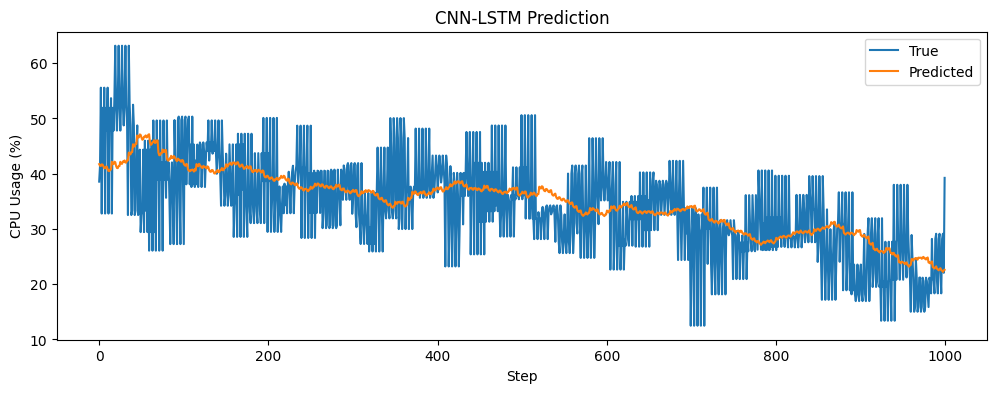

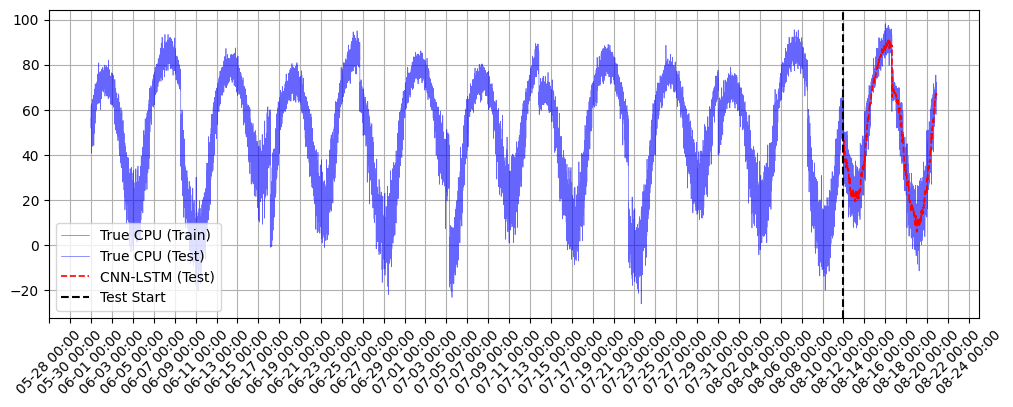

In [99]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # Ï†ÑÏ≤¥ ÏãúÍ∞Ñ index (xÏ∂ï)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test ÏãúÏûë Ï†ÑÍπåÏßÄ

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp Îß§Ìïë
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # ÏÉòÌîå ÎÅùÎÇòÎäî ÏãúÏ†ê + (j+1)*5Î∂Ñ
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

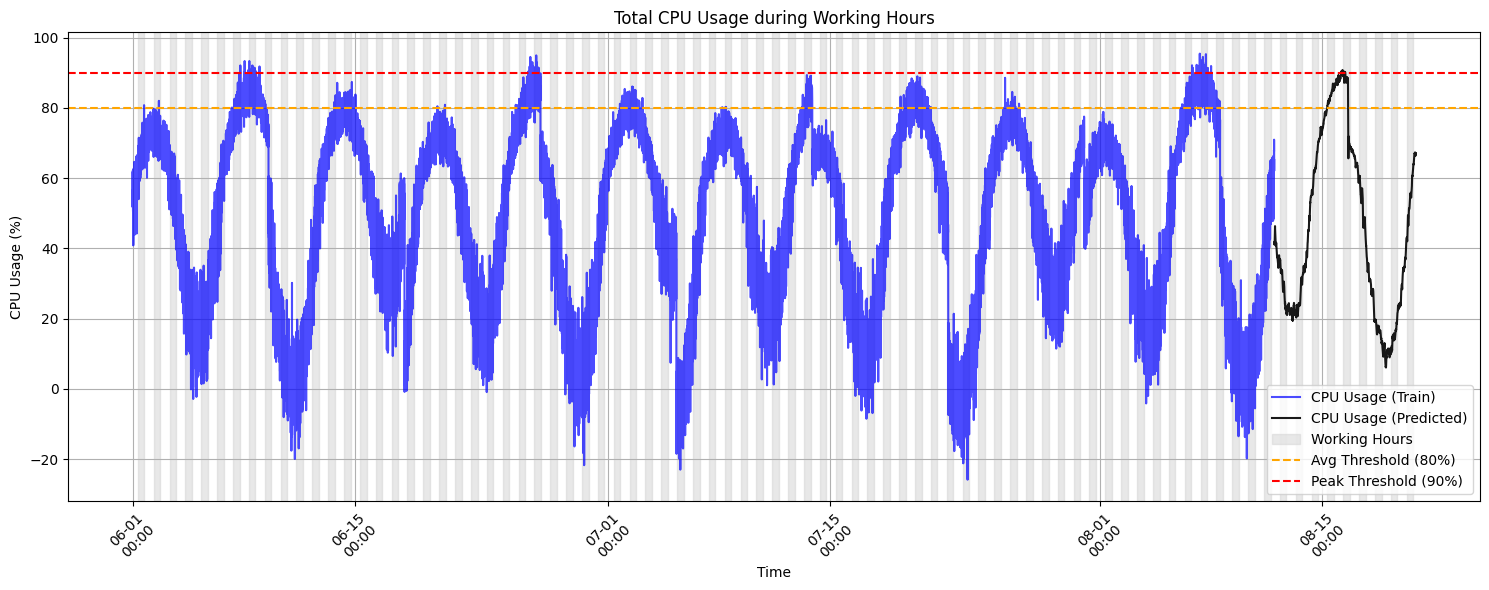

 Condition 1 (Avg CPU during working hours ‚â• 80%): False (48.77%)
 Condition 2 (‚â•80% of days with peak > 90%): False (4/81)
 Final Upgrade Decision:  No Upgrade Required


In [100]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. Ï†ÑÏ≤¥ ÏòàÏ∏° ÏãúÍ≥ÑÏó¥ Íµ¨ÏÑ± (TrainÏùÄ Ïã§Ï†úÍ∞í, TestÎäî ÏòàÏ∏°Í∞í)
all_pred_series = pd.concat([
    df['cpu'][:test_time_index[0]],       # Train Íµ¨Í∞ÑÏùÄ Ïã§Ï†ú Ï∏°Ï†ïÍ∞í
    test_series_pred                      # Test Íµ¨Í∞ÑÏùÄ ÏòàÏ∏°Í∞í
])
all_pred_series.name = "cpu_pred"

# 2. ÏóÖÎ¨¥ÏãúÍ∞Ñ (08:00~18:00)Îßå Ï∂îÏ∂ú
work_time = all_pred_series.between_time("08:00", "18:00")

# 3. Ï°∞Í±¥ 1: ÏóÖÎ¨¥ÏãúÍ∞Ñ ÌèâÍ∑† CPU ÏÇ¨Ïö©Î•† ‚â• 80%
avg_threshold = 80
condition1_flag = work_time.mean() >= avg_threshold

# 4. Ï°∞Í±¥ 2: ÏóÖÎ¨¥ÏãúÍ∞Ñ Ï§ë ÌîºÌÅ¨(‚â•90%) Î∞úÏÉùÌïú ÎÇ†Ïù¥ Ï†ÑÏ≤¥Ïùò 80% Ïù¥ÏÉÅ
peak_threshold = 90
daily_peak_flags = (all_pred_series > peak_threshold).between_time("08:00", "18:00")
daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.8

# 5. Ï¶ùÏÑ§ ÌåêÎã®
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade ÌëúÏãúÌï† ÏãúÍ∞ÑÎåÄ ÏßÄÏ†ï
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    # Ï°∞Í±¥ 2 Ï∂©Ï°± Ïãú peak Î∞úÏÉùÏùº Í∏∞Ï§Ä
    peak_day_list = daily_peak[daily_peak].index[:5]  # ÏµúÎåÄ 5Ïùº
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# 7. ÏãúÍ∞ÅÌôî (TrainÍ≥º Test ÏÉâÏÉÅ Íµ¨Î∂Ñ)
fig, ax = plt.subplots(figsize=(15, 6))

# Train Íµ¨Í∞Ñ
train_series = df['cpu'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Test Íµ¨Í∞Ñ
ax.plot(test_series_pred.index, test_series_pred.values, label="CPU Usage (Predicted)", color="black",alpha=0.9)

# ÏóÖÎ¨¥ÏãúÍ∞Ñ Î∞∞Í≤Ω ÏÉâÏπ†
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # Ï≤´ Î≤àÏß∏ÏóêÎßå ÎùºÎ≤® Î∂ÄÏó¨
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# Í∏∞Ï§ÄÏÑ†
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# ÏóÖÍ∑∏Î†àÏù¥Îìú Ïã†Ìò∏ ÌëúÏãú
if len(upgrade_times) > 0:
    ax.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# ÎßàÎ¨¥Î¶¨ ÏÑ§Ï†ï
ax.set_title("Total CPU Usage during Working Hours")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()


# 8. Í≤∞Í≥º Ï∂úÎ†•
print(f" Condition 1 (Avg CPU during working hours ‚â• 80%): {condition1_flag} ({work_time.mean():.2f}%)")
print(f" Condition 2 (‚â•80% of days with peak > 90%): {condition2_flag} ({peak_days}/{total_days})")
print(f" Final Upgrade Decision: {'Upgrade Needed' if upgrade_flag else ' No Upgrade Required'}")


In [101]:
# streamlit ÏúÑÌïú csv Ï†ÄÏû•
import json
with open("cpu_accuracy_metrics.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("all_series.csv") # Ï†ÑÏ≤¥ cpu
test_series_pred.to_csv("cpu_usage_predicted_only.csv") # ÏòàÏ∏° Íµ¨Í∞Ñ cpu
work_time.to_csv("cpu_usage_working_hours.csv") # ÏóÖÎ¨¥ÏãúÍ∞Ñ cpu
daily_peak.to_csv("cpu_peak_flag_per_day.csv") # peak Î∞úÏÉù Ïó¨Î∂Ä

with open("upgrade_decision.txt", "w") as f: # ÏóÖÍ∑∏Î†àÏù¥Îìú Ïú†Î¨¥
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")

!pip install streamlit

In [104]:
import os
# 1. ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
os.makedirs("cpu_dashboard", exist_ok=True)

# 2. app.py ÏΩîÎìú Î¨∏ÏûêÏó¥ (Streamlit ÏΩîÎìú Ï†ÑÏ≤¥ Î≥µÏÇ¨Ìï¥ÏÑú Ïó¨Í∏∞Ïóê Î∂ôÏó¨ÎÑ£Í∏∞)
code = '''import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

# --- ÌååÏùº Î∂àÎü¨Ïò§Í∏∞ ---
df_all = pd.read_csv("all_series2.csv", index_col=0, parse_dates=True)
df_pred = pd.read_csv("cpu_usage_predicted_only2.csv", index_col=0, parse_dates=True)
df_work = pd.read_csv("cpu_usage_working_hours2.csv", index_col=0, parse_dates=True)
df_peak = pd.read_csv("cpu_peak_flag_per_day2.csv", index_col=0, parse_dates=True)

# --- Ï°∞Í±¥ Ïû¨Í≥ÑÏÇ∞ ---
avg_threshold = 80
peak_threshold = 90

avg_cpu = df_work.values.mean()
condition1_flag = avg_cpu >= avg_threshold

peak_days = df_peak.values.sum()
total_days = len(df_peak)
condition2_flag = (peak_days / total_days) >= 0.8

upgrade_flag = condition1_flag or condition2_flag

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ï†ïÌôïÎèÑ Î∂àÎü¨Ïò§Í∏∞
with open("cpu_accuracy_metrics2.json", "r") as f:
    metrics = json.load(f)

# --- ÏóÖÍ∑∏Î†àÏù¥Îìú ÌëúÏãú ÏãúÍ∞Ñ Ï∂îÏ∂ú ---
if condition1_flag:
    upgrade_times = df_work.index
elif condition2_flag:
    peak_day_list = df_peak[df_peak.values.flatten()].index[:5]
    upgrade_times = df_work[df_work.index.date.astype(str).isin(peak_day_list.astype(str))].index
else:
    upgrade_times = []

# --- Streamlit Ï∂úÎ†• ---
st.markdown("<h1 style='font-size:30px;'>üìà CPU ÏÇ¨Ïö©Îüâ Î∞è Ï¶ùÏÑ§ ÌåêÎã®</h1>", unsafe_allow_html=True)
st.markdown("#### 2. ÎÖ∏Ïù¥Ï¶à ÎßéÏùÄ Îç∞Ïù¥ÌÑ∞")

st.markdown("#### ÌïôÏäµÎ™®Îç∏ : CNN-LSTM")

# ÌëúÏãú
st.markdown("#### üìä ÏòàÏ∏° Ï†ïÌôïÎèÑ")
st.markdown(f"- **MAE**: {metrics['MAE']}")
st.markdown(f"- **RMSE**: {metrics['RMSE']}")
st.markdown(f"- **R¬≤ Score**: {metrics['R2']}")

st.markdown("#### üîç Ï¶ùÏÑ§ ÌåêÎã®")
st.markdown(f"<p style='font-size:18px'><b>Ï°∞Í±¥ 1.</b> (ÏóÖÎ¨¥ÏãúÍ∞ÑÏùò ÌèâÍ∑† CPU ÏÇ¨Ïö©Îüâ ‚â• 80%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
st.markdown(f"<p style='font-size:18px'><b>Ï°∞Í±¥ 2.</b> (ÏóÖÎ¨¥ÏãúÍ∞Ñ Ï§ë CPU ÏÇ¨Ïö©Î•†Ïù¥ 90%Î•º Ï¥àÍ≥ºÌïú ÎÇ†Ïù¥ Ï†ÑÏ≤¥Ïùò 80% Ïù¥ÏÉÅÏù∏ Í≤ΩÏö∞): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

# Í≤∞Í≥º Í∞ïÏ°∞
result_text = 'üü• <b>Ï¶ùÏÑ§ ÌïÑÏöî</b>' if upgrade_flag else 'üü© <b>Ï¶ùÏÑ§ Î∂àÌïÑÏöî</b>'
st.markdown(f"<h3>‚úÖ ÏµúÏ¢Ö ÌåêÎã®: {result_text}</h3>", unsafe_allow_html=True)

# --- Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî ---
fig, ax = plt.subplots(figsize=(15, 6))

# Train / Test ÎÇòÎàÑÍ∏∞
split_idx = df_pred.index[0]
train_series = df_all[df_all.index < split_idx]
test_series = df_pred.squeeze()

# Train plot
ax.plot(train_series.index, train_series.values, label="CPU Usage (Train)", color="blue", alpha=0.7)

# Test plot
ax.plot(test_series.index, test_series.values, label="CPU Usage (Predicted)", color="black", alpha=0.9)

# Working hours shading
first = True
unique_dates = pd.to_datetime(df_all.index.date).unique()
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# Threshold lines
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (80%)")
ax.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")

# Upgrade signal
if len(upgrade_times) > 0:
    ax.scatter(upgrade_times, df_work.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5, s=20)

# ÎßàÎ¨¥Î¶¨ ÏÑ§Ï†ï
ax.set_title("Total CPU Usage with Working Hours Highlighted")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

# StreamlitÏóê ÌëúÏãú
st.pyplot(fig)

from fpdf import FPDF

st.markdown("---")
st.markdown("### üìù PDF Î≥¥Í≥†ÏÑú ÎßåÎì§Í∏∞")

# --- Ï≤¥ÌÅ¨Î∞ïÏä§ ÏÑ†ÌÉù
include_accuracy = st.checkbox("ÏòàÏ∏° Ï†ïÌôïÎèÑ Ìè¨Ìï®", value=True)
include_conditions = st.checkbox("Ï¶ùÏÑ§ Ï°∞Í±¥ ÌåêÎã® Ìè¨Ìï®", value=True)
include_chart = st.checkbox("CPU ÏÇ¨Ïö©Îüâ Í∑∏ÎûòÌîÑ Ìè¨Ìï®", value=True)

if st.button("üìÑ PDFÎ°ú Ï†ÄÏû•ÌïòÍ∏∞"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.set_title("CPU Usage Report")

    pdf.cell(200, 10, txt="üìà CPU ÏÇ¨Ïö©Îüâ Î∞è Ï¶ùÏÑ§ ÌåêÎã® Î≥¥Í≥†ÏÑú", ln=True, align="L")

    if include_accuracy:
        pdf.ln(10)
        pdf.set_font("Arial", style='B', size=12)
        pdf.cell(200, 10, txt="ÏòàÏ∏° Ï†ïÌôïÎèÑ", ln=True)
        pdf.set_font("Arial", size=11)
        pdf.cell(200, 8, txt=f"- MAE: {metrics['MAE']}", ln=True)
        pdf.cell(200, 8, txt=f"- RMSE: {metrics['RMSE']}", ln=True)
        pdf.cell(200, 8, txt=f"- R¬≤ Score: {metrics['R2']}", ln=True)

    if include_conditions:
        pdf.ln(10)
        pdf.set_font("Arial", style='B', size=12)
        pdf.cell(200, 10, txt="Ï¶ùÏÑ§ Ï°∞Í±¥ ÌåêÎã®", ln=True)
        pdf.set_font("Arial", size=11)
        pdf.cell(200, 8, txt=f"Ï°∞Í±¥ 1: {condition1_flag} ({avg_cpu:.2f}%)", ln=True)
        pdf.cell(200, 8, txt=f"Ï°∞Í±¥ 2: {condition2_flag} ({int(peak_days)}/{total_days})", ln=True)
        decision = "Ï¶ùÏÑ§ ÌïÑÏöî" if upgrade_flag else "Ï¶ùÏÑ§ Î∂àÌïÑÏöî"
        pdf.cell(200, 8, txt=f"ÏµúÏ¢Ö ÌåêÎã®: {decision}", ln=True)

    if include_chart:
        # Í∑∏ÎûòÌîÑÎ•º Ïù¥ÎØ∏ÏßÄÎ°ú Ï†ÄÏû•
        chart_path = "cpu_dashboard/temp_chart.png"
        fig.savefig(chart_path, bbox_inches='tight')
        pdf.ln(10)
        pdf.set_font("Arial", style='B', size=12)
        pdf.cell(200, 10, txt="CPU ÏÇ¨Ïö©Îüâ Í∑∏ÎûòÌîÑ", ln=True)
        pdf.image(chart_path, x=10, w=190)

    output_path = r"C:\jupyter\cpu_dashboard\cpu_report.pdf"
    pdf.output(output_path)

    st.success(f"PDF Î≥¥Í≥†ÏÑúÍ∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§: `{output_path}`")
    st.download_button("üì• PDF Îã§Ïö¥Î°úÎìú", data=open(output_path, "rb"), file_name="cpu_report.pdf")


'''

# ÌååÏùº Ï†ÄÏû•
with open("cpu_dashboard/app.py", "w", encoding="utf-8") as f:
    f.write(code)


# Ï†ÄÏû•ÌõÑÏóê bashÏóêÏÑú streamlit run app.py ÏûÖÎ†•

## Í∏∞Ï§Ä Îî∞ÎùºÏÑú Ï¶ùÏÑ§ ÏãúÏ†ê Ï†ïÌïòÍ∏∞

average CPU :  59.94489


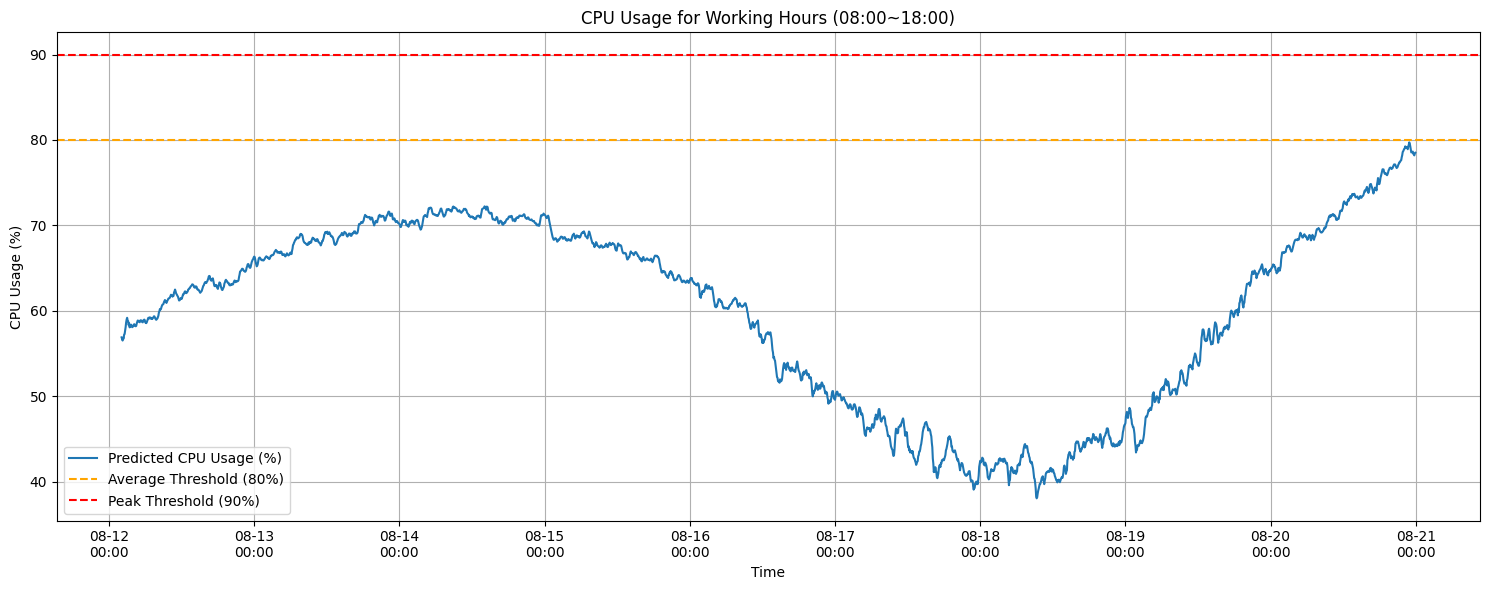

‚úÖ Condition 1 (Avg CPU during working hours ‚â• 80%): False
‚úÖ Condition 2 (‚â•5 days with peak > 90% during working hours): False
üîç Final Upgrade Decision: üü© No Upgrade Required


In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ÏóÖÎ¨¥ÏãúÍ∞Ñ ÌïÑÌÑ∞ÎßÅ
test_time_index = df.index[split_point + past_steps + future_steps : split_point + past_steps + future_steps + len(pred_inv)]
time_series = pd.Series(pred_inv.mean(axis=1), index=test_time_index)
work_time = time_series.between_time("08:00", "18:00")

# Ï°∞Í±¥ 1: Ï†ÑÏ≤¥ ÏóÖÎ¨¥ÏãúÍ∞Ñ ÌèâÍ∑†Ïù¥ 80% Ïù¥ÏÉÅ ---
avg_threshold = 80
condition1_flag = work_time.mean() >= avg_threshold
print("average CPU : ", work_time.mean() )

# Ï°∞Í±¥ 2: ÏóÖÎ¨¥ÏãúÍ∞Ñ ÎÇ¥ ÌîºÌÅ¨Í∞Ä Îß§Ïùº 1Ìöå Ïù¥ÏÉÅ Î∞úÏÉùÌïú ÎÇ†Ïù¥ 80% Ïù¥ÏÉÅ ---
peak_threshold = 90
work_peak_flags = pd.Series((pred_inv > peak_threshold).any(axis=1), index=test_time_index).between_time("08:00", "18:00")

# ÌîºÌÅ¨Í∞Ä Î∞úÏÉùÌñàÎäîÏßÄ Ïó¨Î∂Ä
daily_peak = work_peak_flags.groupby(work_peak_flags.index.date).any()

# Ï†ÑÏ≤¥ Ïùº Ïàò Ï§ë ÌîºÌÅ¨Í∞Ä Î∞úÏÉùÌïú ÎπÑÏú®Ïù¥ 80% Ïù¥ÏÉÅÏù∏ÏßÄ
total_days = len(daily_peak)
peak_days = daily_peak.sum()
condition2_flag = (peak_days / total_days) >= 0.8

# Ï°∞Í±¥1,2 ÍµêÏßëÌï©ÏúºÎ°ú ÌåêÎã®
upgrade_flag = condition1_flag or condition2_flag

# Ï¶ùÏÑ§ ÌÉÄÏù¥Î∞ç ÏãúÍ∞ÅÌôîÏö© ÌëúÏãú
if condition1_flag:
    upgrade_times = work_time.index
elif condition2_flag:
    peak_days = daily_peak_count[daily_peak_count >= 1].index[:5]  # Ï≤òÏùå 5ÏùºÎßå ÌëúÏãú
    upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_days.astype(str))].index
else:
    upgrade_times = []

plt.figure(figsize=(15, 6))
plt.plot(time_series.index, time_series.values, label="Predicted CPU Usage (%)")
plt.axhline(avg_threshold, color='orange', linestyle='--', label="Average Threshold (80%)")
plt.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")
if len(upgrade_times) > 0:
    plt.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5)
plt.title("CPU Usage for Working Hours (08:00~18:00)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.tight_layout()
plt.show()

# Í≤∞Í≥º Ï∂úÎ†•
print(f"‚úÖ Condition 1 (Avg CPU during working hours ‚â• 80%): {condition1_flag}")
print(f"‚úÖ Condition 2 (‚â•5 days with peak > 90% during working hours): {condition2_flag}")
print(f"üîç Final Upgrade Decision: {'üü• Upgrade Needed' if upgrade_flag else 'üü© No Upgrade Required'}")


üö® Upgrade Timing Detected: 2025-06-15 08:00:00


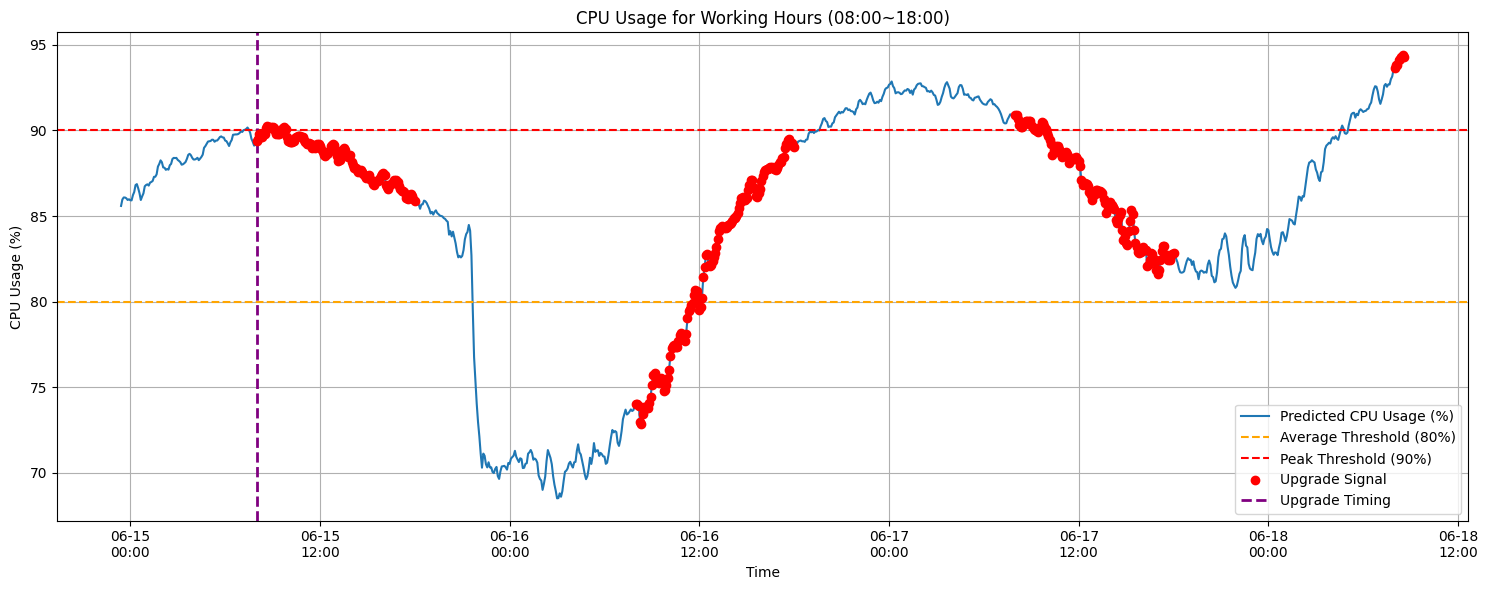

In [ ]:
# --- ‚úÖ Ï¶ùÏÑ§ ÏãúÏ†ê ÌåêÎã® (Ï≤òÏùå Ï°∞Í±¥ ÎßåÏ°±Ìïú ÏãúÏ†ê ÌïòÎÇòÎßå Ï∂îÏ∂ú) ---
if len(upgrade_times) > 0:
    upgrade_time_final = upgrade_times[0]  # Ï≤´ Î≤àÏß∏ Î∞úÏÉù ÏãúÏ†ê
    print(f"üö® Upgrade Timing Detected: {upgrade_time_final}")
else:
    upgrade_time_final = None
    print("‚úÖ No upgrade timing detected.")

# ÏãúÍ∞ÅÌôî (Í∏∞Ï°¥ ÏΩîÎìú Ïú†ÏßÄ)
plt.figure(figsize=(15, 6))
plt.plot(time_series.index, time_series.values, label="Predicted CPU Usage (%)")
plt.axhline(avg_threshold, color='orange', linestyle='--', label="Average Threshold (80%)")
plt.axhline(peak_threshold, color='red', linestyle='--', label="Peak Threshold (90%)")
if len(upgrade_times) > 0:
    plt.scatter(upgrade_times, work_time.loc[upgrade_times], color='red', label="Upgrade Signal", zorder=5)

# ‚úÖ Ï≤´ Ï¶ùÏÑ§ ÏãúÏ†êÏùÑ ÏÑ†ÏúºÎ°ú ÏãúÍ∞ÅÌôî
if upgrade_time_final:
    plt.axvline(x=upgrade_time_final, color='purple', linestyle='--', linewidth=2, label='Upgrade Timing')

plt.title("CPU Usage for Working Hours (08:00~18:00)")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
plt.tight_layout()
plt.show()


## 2. Îã®Ïàú CNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# np.random.seed(42)
# days = 30
# points_per_day = 24 * 12  # 5Î∂Ñ Í∞ÑÍ≤©
# total_points = days * points_per_day

# time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
# cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
# df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# scaler = MinMaxScaler()
# cpu_scaled =pd.DataFrame( scaler.fit_transform(df[['cpu']]))

# # Ï†ïÍ∑úÌôîÎäî trainÎßå fit
# split_point = int(len(cpu_scaled) * 0.8)
# df_train = cpu_scaled.iloc[:split_point]
# df_test = cpu_scaled.iloc[split_point:]


# ÏãúÌÄÄÏä§ ÏÉùÏÑ±
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

# train/test ÏãúÌÄÄÏä§ Íµ¨ÏÑ±
X_train, y_train = create_sequences(df_train, past_steps, future_steps)

# testÎäî train ÎßàÏßÄÎßâ 20Í∞úÏôÄ test ÏïûÎ∂ÄÎ∂ÑÏùÑ Ïù¥Ïñ¥Î∂ôÏó¨ Íµ¨ÏÑ±
# test_base = np.concatenate([cpu_train_scaled[-past_steps:], cpu_test_scaled])
# X_test, y_test = create_sequences(test_base, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

# CNN-only Î™®Îç∏
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# reshape for Conv1D
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, verbose=1)
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)

pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 0.0183
Epoch 2/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 3.3728e-04
Epoch 3/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - loss: 3.2120e-04
Epoch 4/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2ms/step - loss: 2.8663e-04
Epoch 5/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 2.7621e-04
Epoch 6/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 2.7079e-04
Epoch 7/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 2.5752e-04
Epoch 8/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 2.5329e-04
Epoch 9/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step - loss: 2.5420e-04
Epoch 10/20
431/

CNN
MAE : 0.530452758231582
RMSE: 0.6644753371208622
R¬≤  : 0.9903779431306562


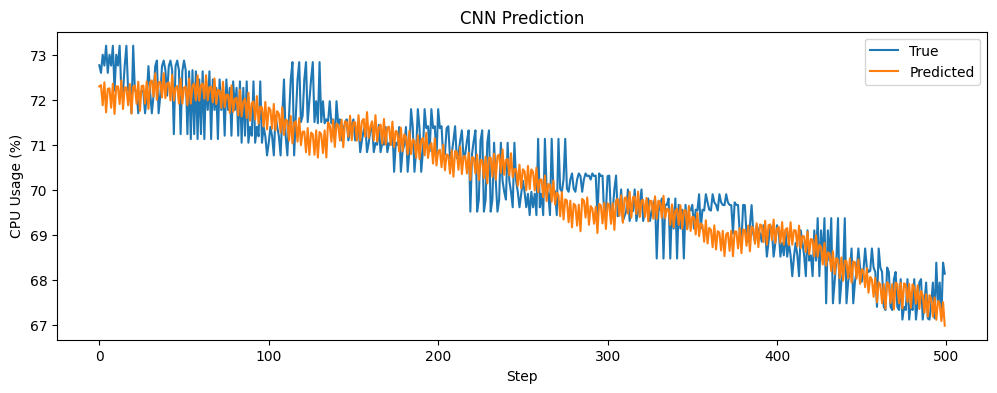

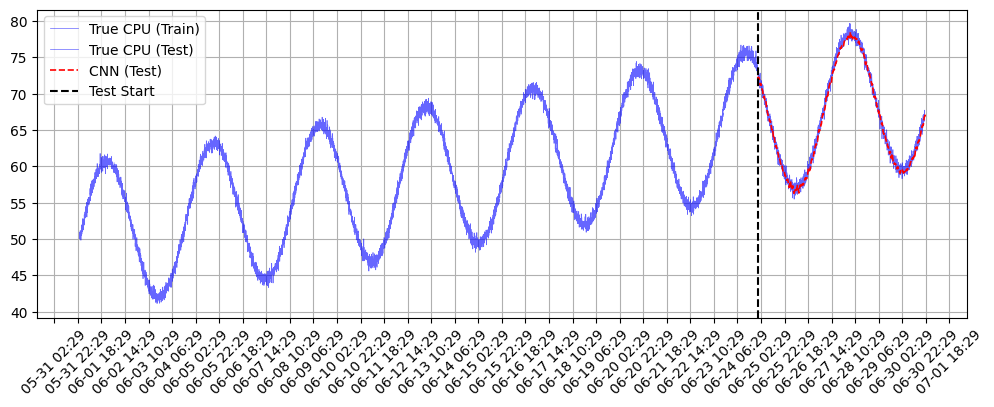

In [ ]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R¬≤  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # Ï†ÑÏ≤¥ ÏãúÍ∞Ñ index (xÏ∂ï)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test ÏãúÏûë Ï†ÑÍπåÏßÄ

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp Îß§Ìïë
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # ÏÉòÌîå ÎÅùÎÇòÎäî ÏãúÏ†ê + (j+1)*5Î∂Ñ
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20ÏãúÍ∞Ñ Í∞ÑÍ≤©
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

## 3. CNN-LSTM + Autoregressive , (20Í∞ú Í≥ºÍ±∞ ‚Üí 1Í∞ú ÎØ∏Îûò)Î•º Î∞òÎ≥µÌï¥ ÌïòÎÇòÏî© ÏòàÏ∏°

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# 1. Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
np.random.seed(42)
days = 30
points_per_day = 24 * 12  # 5Î∂Ñ Í∞ÑÍ≤©
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points, freq='5min')
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + \
      np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu}).set_index('timestamp')

# 2. Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
cpu_scaled = pd.DataFrame(scaler.fit_transform(df[['cpu']]), index=df.index, columns=['cpu'])

# 3. train/test Î∂ÑÌï†
split_point = int(len(cpu_scaled) * 0.8)
df_train = cpu_scaled.iloc[:split_point]
df_test = cpu_scaled.iloc[split_point:]

# 4. ÏãúÌÄÄÏä§ ÏÉùÏÑ± Ìï®Ïàò
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps].values)
        y.append(dataset[i+past_steps:i+past_steps+future_steps].values)
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5

X_train, y_train = create_sequences(df_train, past_steps, future_steps)
X_test, y_test = create_sequences(df_test, past_steps, future_steps)

# 5. CNN-LSTM Î™®Îç∏ Ï†ïÏùò
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

# 6. ÌïôÏäµ (reshape ÌïÑÏöî)
model.fit(X_train.reshape((-1, past_steps, 1)),
          y_train.reshape((y_train.shape[0], -1)),
          epochs=10, batch_size=16, verbose=1)

# 7. Autoregressive Î∞©ÏãùÏúºÎ°ú ÏòàÏ∏°
test_base = np.concatenate([df_train[-past_steps:], df_test])  # context Ï∂îÍ∞Ä
preds, truths = [], []

for i in range(0, len(test_base) - past_steps - future_steps):
    input_seq = test_base[i:i+past_steps].values.reshape(1, past_steps, 1)
    pred_seq = []
    for _ in range(future_steps):
        pred = model.predict(input_seq, verbose=0)
        pred_seq.append(pred[0][0])
        input_seq = np.append(input_seq[:, 1:, :], [[[pred[0][0]]]], axis=1)
    preds.append(pred_seq)
    truths.append(test_base[i+past_steps:i+past_steps+future_steps].values.flatten())

preds_inv = scaler.inverse_transform(np.array(preds))
truths_inv = scaler.inverse_transform(np.array(truths))

# 8. ÏÑ±Îä• ÌèâÍ∞Ä
print("CNN-LSTM (Autoregressive)")
print("MAE :", mean_absolute_error(truths_inv, preds_inv))
print("RMSE:", np.sqrt(mean_squared_error(truths_inv, preds_inv)))
print("R¬≤  :", r2_score(truths_inv, preds_inv))

# 9. ÏãúÍ∞ÅÌôî: ÏòàÏ∏° ÏùºÎ∂Ä
plt.figure(figsize=(12, 4))
plt.plot(truths_inv[:500].flatten(), label="True")
plt.plot(preds_inv[:500].flatten(), label="Predicted")
plt.title("CNN-LSTM (Autoregressive) Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

# 10. ÏãúÍ∞ÅÌôî: Ï†ÑÏ≤¥ ÏãúÍ≥ÑÏó¥ Í∏∞Î∞ò Í∑∏ÎûòÌîÑ
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx:test_start_idx + len(truths)]
train_series = df['cpu'][:test_start_idx]
test_series_true = pd.Series(truths_inv.flatten(), index=test_time_index)

# ÏòàÏ∏° ÏãúÍ≥ÑÏó¥ ÏÉùÏÑ±
all_future_times = []
all_future_preds = []
future_interval = 5

for i in range(len(test_time_index)):
    for j in range(future_steps):
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(preds_inv[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": np.array(all_future_preds)})
pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'].values, index=pred_df_mean.index)

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(12, 4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - loss: 0.0380
Epoch 2/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 6ms/step - loss: 3.3442e-04
Epoch 3/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 6ms/step - loss: 3.2458e-04
Epoch 4/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 9ms/step - loss: 3.1066e-04
Epoch 5/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 6ms/step - loss: 2.9646e-04
Epoch 6/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 6ms/step - loss: 2.7966e-04
Epoch 7/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 7ms/step - loss: 2.6901e-04
Epoch 8/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 6ms/step - loss: 2.7161e-04
Epoch 9/10
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 6ms/step - loss: 2.8235e-04
Epoch 10/10
431/

AttributeError: 'numpy.ndarray' object has no attribute 'values'

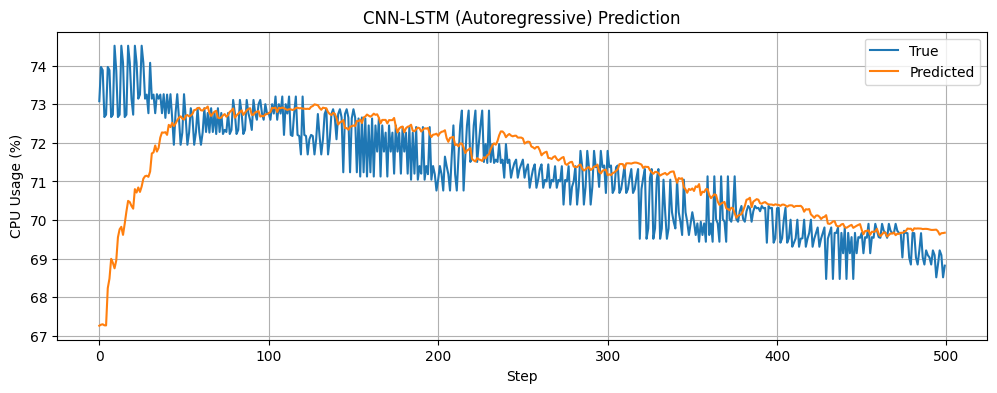

ValueError: Length of values (1723) does not match length of index (1708)

In [ ]:
# plot
# Plot 1: ÏòàÏ∏° vs Ïã§Ï†ú
plt.figure(figsize=(12, 4))
plt.plot(truths_inv.flatten()[:500], label="True")
plt.plot(preds_inv.flatten()[:500], label="Predicted")
plt.title("CNN-LSTM (Autoregressive) Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Ï†ÑÏ≤¥ ÏãúÍ∞Ñ ÏãúÍ≥ÑÏó¥ Í∏∞Î∞ò
test_start_idx = split_point + past_steps
# ÌïÑÏöîÌïú Ïù∏Îç±Ïä§ Í∏∏Ïù¥Îäî truths_invÏôÄ ÎèôÏùºÌïòÍ≤å ÏÑ§Ï†ï
test_time_index = df.index[test_start_idx : test_start_idx + len(truths_inv)]

# Í∑∏Ïóê ÎßûÏ∂∞ ÏãúÎ¶¨Ï¶à ÏÉùÏÑ±
test_series_true = pd.Series(truths_inv[:, 0], index=test_time_index)

train_series = df['cpu'][:test_start_idx]

# ÏòàÏ∏° ÏãúÍ≥ÑÏó¥ ÏÉùÏÑ±
all_future_times = []
all_future_preds = []
future_interval = 5

for i in range(len(test_time_index)):
    for j in range(future_steps):
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(preds[i, j])

pred_df = pd.DataFrame({
    "time": all_future_times,
    "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()
})
pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index)

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Autoregressive)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.legend()
plt.grid(True)
plt.show()

# ÏÑ±Îä• Ï∂úÎ†•
print("MAE :", mae)
print("RMSE:", rmse)
print("R¬≤  :", r2)

## 4. FLNN + GA-PSO

In [ ]:
# ========== FLNN Ï†ïÏùò ==========
def flnn_predict(w, X):
    return np.dot(X, w[:-1]) + w[-1]

def eval(ind):
    return (np.abs(flnn_predict(np.array(ind), X_train) - y_train).mean(),)

# GA Íµ¨ÏÑ±
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=past_steps+1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", eval)

pop = toolbox.population(n=30)
pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=15, verbose=False)
best_ga = tools.selBest(pop, 1)[0]

# PSO
def pso_obj(w):
    return np.array([np.abs(flnn_predict(p, X_train) - y_train).mean() for p in w])

optimizer = ps.single.GlobalBestPSO(
    n_particles=20,
    dimensions=past_steps+1,
    options={'c1':1.5, 'c2':1.5, 'w':0.7},
    init_pos=np.tile(best_ga, (20, 1)) + np.random.normal(0, 0.1, (20, past_steps+1))
)
_, best_pso = optimizer.optimize(pso_obj, iters=100)

# ÏòàÏ∏° Î∞è Î≥µÏõê
y_pred = flnn_predict(best_pso, X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))
y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# ÌèâÍ∞Ä Ï∂úÎ†•
print("FLNN-GA-PSO")
print("MAE :", mean_absolute_error(y_true_inv, y_pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(y_true_inv, y_pred_inv)))
print("R¬≤  :", r2_score(y_true_inv, y_pred_inv))

# ÏãúÍ∞ÅÌôî (Ïïû 500Í∞ú)
plt.figure(figsize=(12, 4))
plt.plot(y_true_inv[:500], label="True")
plt.plot(y_pred_inv[:500], label="Predicted")
plt.title("FLNN-GA-PSO Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


ValueError: shapes (6887,20,1) and (20,) not aligned: 1 (dim 2) != 20 (dim 0)

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Ï†ÑÏ≤¥ ÏãúÍ∞Ñ Ïù∏Îç±Ïä§
full_time_index = df.index

# test ÏãúÏûë ÏúÑÏπò Í≥ÑÏÇ∞ (train ÎÅù + Ïä¨ÎùºÏù¥Îî© past_steps Î≥¥Ï†ï)
test_start_idx = len(df_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

# Train Îç∞Ïù¥ÌÑ∞ Ïã§Ï†úÍ∞í (Î≥µÏõê Ï†Ñ ÏõêÎûò Í∞í)
train_series = df['cpu'][:test_start_idx]

# Test Íµ¨Í∞Ñ Ïã§Ï†úÍ∞í, ÏòàÏ∏°Í∞í ÏãúÎ¶¨Ï¶à ÏÉùÏÑ±
test_series_true = pd.Series(y_true_inv, index=test_time_index)
test_series_pred = pd.Series(y_pred_inv, index=test_time_index)

# ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.6, linewidth=0.5)
plt.plot(test_series_pred, label="FLNN-GA-PSO (Predicted)", color="red", linestyle="--", linewidth=1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200))  # 20ÏãúÍ∞Ñ Í∞ÑÍ≤©
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.title("FLNN-GA-PSO Train + Test CPU Prediction")
plt.xlabel("Time")
plt.ylabel("CPU Usage (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (858, 1) instead

In [ ]:
y_train.shape

(6906,)

## 2. CNN-BiLSTM + sliding window (5) + CNN 2Ï∏µ ÏåìÍ∏∞

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv1d_11 (Conv1D)              ‚îÇ (None, 18, 64)         ‚îÇ           256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d_11 (MaxPooling1D) ‚îÇ (None, 9, 64)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_3 (Bidirectional) ‚îÇ (None, 128)            ‚îÇ        66,048 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                ‚îÇ (None, 5)              ‚îÇ           645 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 66,949 (261.52 KB)

 Trainable params: 66,949 (261.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 9ms/step - loss: 0.0153
Epoch 2/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 9ms/step - loss: 4.0003e-04
Epoch 3/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 13ms/step - loss: 4.0601e-04
Epoch 4/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 9ms/step - loss: 3.7590e-04
Epoch 5/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 10ms/step - loss: 3.8263e-04
Epoch 6/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 11ms/step - loss: 3.6662e-04
Epoch 7/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 10ms/step - loss: 3.3312e-04
Epoch 8/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 13ms/step - loss: 3.1545e-04
Epoch 9/20
431/431 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 10ms/step - loss: 3.0060e-04

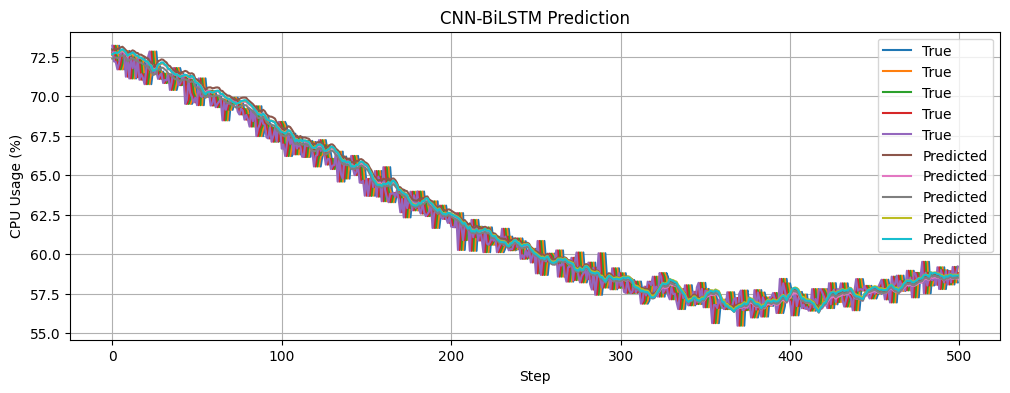

In [ ]:
# reshape y to match CNN-BiLSTM output
y_train_re = y_train.reshape(-1, future_steps)
y_test_re  = y_test.reshape(-1, future_steps)

# ‚úÖ CNN-BiLSTM Î™®Îç∏ Íµ¨ÏÑ±
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, activation='tanh')),
    Dense(future_steps)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# ‚úÖ reshape for Conv1D & LSTM
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# ‚úÖ ÌïôÏäµ
model.fit(X_train_cnn, y_train_re, epochs=20, batch_size=16, verbose=1)

# ‚úÖ ÏòàÏ∏°
pred = model.predict(X_test_cnn).reshape(-1, future_steps)
true = y_test_re.reshape(-1, future_steps)

# ‚úÖ Î≥µÏõê (Ï†ïÍ∑úÌôî ‚Üí ÏõêÎûò Îã®ÏúÑ [%]Î°ú)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

# ‚úÖ ÏÑ±Îä• Ï∂úÎ†•
print("CNN-BiLSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R¬≤  :", r2_score(true_inv, pred_inv))


CNN
MAE : 0.5069721441335628
RMSE: 0.6392430793249102
R¬≤  : 0.9910956102478318


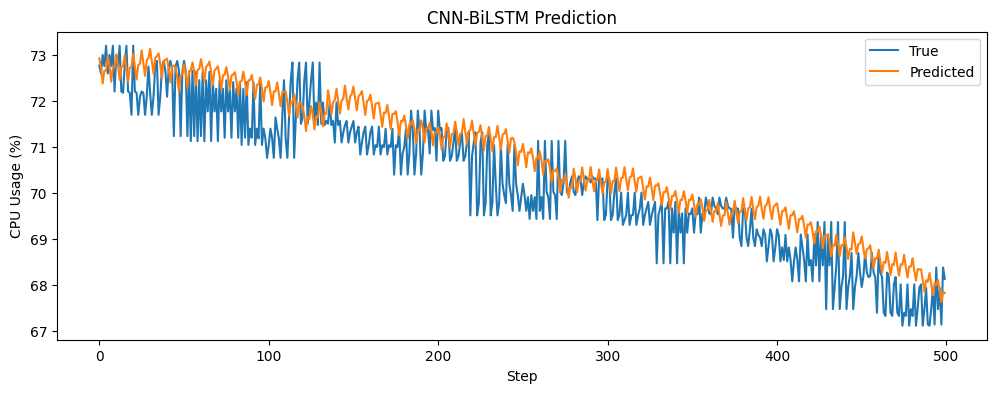

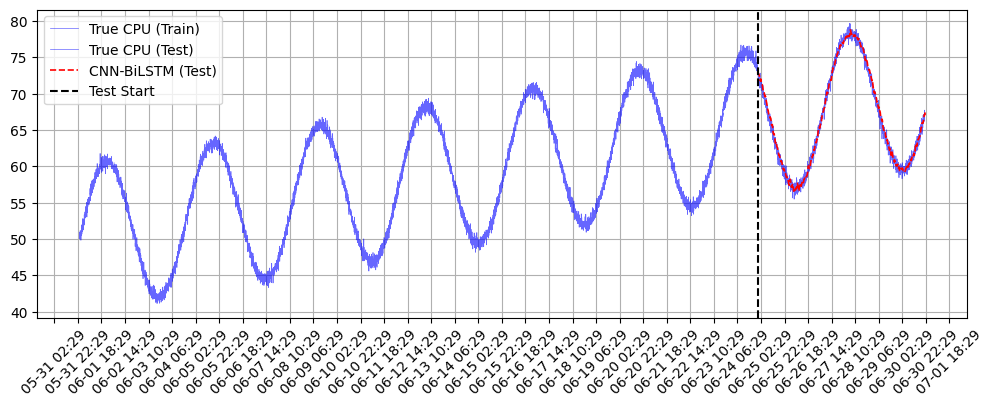

In [ ]:
# plot

print("CNN")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R¬≤  :", r2_score(true_inv, pred_inv))


plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:500], label="True")
plt.plot(pred_inv.flatten()[:500], label="Predicted")
plt.title("CNN-BiLSTM Prediction")
plt.ylabel("CPU Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
full_time_index = df.index  # Ï†ÑÏ≤¥ ÏãúÍ∞Ñ index (xÏ∂ï)
test_start_idx = len(X_train) + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['cpu'][:test_start_idx]  # Test ÏãúÏûë Ï†ÑÍπåÏßÄ

test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp Îß§Ìïë
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # ÏÉòÌîå ÎÅùÎÇòÎäî ÏãúÏ†ê + (j+1)*5Î∂Ñ
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-BiLSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1200)) # 20ÏãúÍ∞Ñ Í∞ÑÍ≤©
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()